<a href="https://colab.research.google.com/github/solved1/test/blob/master/Otoscope_IEEE_paper_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](https://www.tensorflow.org/guide/keras/overview) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Select a threshold for a probabilistic classifier to get a deterministic classifier.
* Try and compare with class weighted modelling and oversampling.

## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
file = tf.keras.utils
raw_df = pd.read_csv('ear_final_graded.csv')
raw_df.head()

,Unnamed: 0,Image,Frame,Right,Left,Score
0,2,1.0,1.0,12221.90625,17012.765625,0
1,3,1.0,2.0,647.080078125,1127.88671875,0
2,4,1.0,3.0,211.013671875,291.87890625,0
3,5,1.0,4.0,13664.328125,15937.546875,0
4,6,1.0,5.0,572.9140625,810.60546875,0


In [ ]:
ear = raw_df.iloc[:,1:]


In [ ]:
ear.iloc[-1]

Image          1058.0
Frame           202.0
Right    113335.21875
Left     115596.96875
Score               0
Name: 212755, dtype: object

In [ ]:
ear

,Image,Frame,Right,Left,Score
0,1.0,1.0,12221.90625,17012.765625,0
1,1.0,2.0,647.080078125,1127.88671875,0
2,1.0,3.0,211.013671875,291.87890625,0
3,1.0,4.0,13664.328125,15937.546875,0
4,1.0,5.0,572.9140625,810.60546875,0
...,...,...,...,...,...
212751,1058.0,198.0,1379.5078125,1601.5625,0
212752,1058.0,199.0,70134.53125,71327.546875,0
212753,1058.0,200.0,112258.3671875,114830.375,0
212754,1058.0,201.0,3447.6171875,11639.828125,0


In [ ]:
ear[['Score']].sum()

Score    16158
dtype: int64

In [ ]:
raw_df.describe()

,Unnamed: 0,Image,Frame,Score
count,212756.000000,212752.000000,212752.000000,212756.000000
mean,106379.500000,530.190983,101.437129,0.075946
std,61417.511273,305.621868,58.286369,0.264913
min,2.000000,1.000000,1.000000,0.000000
25%,53190.750000,266.000000,51.000000,0.000000
50%,106379.500000,531.000000,101.000000,0.000000
75%,159568.250000,794.000000,152.000000,0.000000
max,212757.000000,1058.000000,203.000000,1.000000


In [ ]:
raw_df.shape

(212756, 6)

In [ ]:
raw_df[['Left', 'Right']].describe()

,Left,Right
count,212756,212756
unique,81990,82011
top,inf,inf
freq,129618,129618


In [ ]:
neg, pos = np.bincount(raw_df['Score'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 212756
    Positive: 16158 (7.59% of total)



This shows the small fraction of positive samples.

In [ ]:
raw_df.iloc[:,3:]

,Right,Left,Score
0,12221.90625,17012.765625,0
1,647.080078125,1127.88671875,0
2,211.013671875,291.87890625,0
3,13664.328125,15937.546875,0
4,572.9140625,810.60546875,0
...,...,...,...
212751,1379.5078125,1601.5625,0
212752,70134.53125,71327.546875,0
212753,112258.3671875,114830.375,0
212754,3447.6171875,11639.828125,0


In [ ]:
cleaned_df = raw_df.copy()
#cleaned_df = raw_df.iloc[:,5:]
# You don't want the `Time` column.
#cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
#eps = 0.001 # 0 => 0.1¢
#cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

In [ ]:
cleaned_df

,Unnamed: 0,Image,Frame,Right,Left,Score
0,2,1.0,1.0,12221.90625,17012.765625,0
1,3,1.0,2.0,647.080078125,1127.88671875,0
2,4,1.0,3.0,211.013671875,291.87890625,0
3,5,1.0,4.0,13664.328125,15937.546875,0
4,6,1.0,5.0,572.9140625,810.60546875,0
...,...,...,...,...,...,...
212751,212753,1058.0,198.0,1379.5078125,1601.5625,0
212752,212754,1058.0,199.0,70134.53125,71327.546875,0
212753,212755,1058.0,200.0,112258.3671875,114830.375,0
212754,212756,1058.0,201.0,3447.6171875,11639.828125,0


In [ ]:
cleaned_df.dtypes

Unnamed: 0      int64
Image         float64
Frame         float64
Right          object
Left           object
Score           int64
dtype: object

In [ ]:
cleaned_df['Right'] = pd.to_numeric(cleaned_df['Right'], errors='coerce')
cleaned_df['Left'] = pd.to_numeric(cleaned_df['Left'], errors='coerce')

In [ ]:
cleaned_df.dtypes

Unnamed: 0      int64
Image         float64
Frame         float64
Right         float64
Left          float64
Score           int64
dtype: object

In [ ]:

cleaned_df

,Unnamed: 0,Image,Frame,Right,Left,Score
0,2,1.0,1.0,12221.906250,17012.765625,0
1,3,1.0,2.0,647.080078,1127.886719,0
2,4,1.0,3.0,211.013672,291.878906,0
3,5,1.0,4.0,13664.328125,15937.546875,0
4,6,1.0,5.0,572.914062,810.605469,0
...,...,...,...,...,...,...
212751,212753,1058.0,198.0,1379.507812,1601.562500,0
212752,212754,1058.0,199.0,70134.531250,71327.546875,0
212753,212755,1058.0,200.0,112258.367188,114830.375000,0
212754,212756,1058.0,201.0,3447.617188,11639.828125,0


In [ ]:
cleaned_df.describe()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Unnamed: 0,Image,Frame,Right,Left,Score
count,212756.000000,212752.000000,212752.000000,2.127520e+05,2.127520e+05,212756.000000
mean,106379.500000,530.190983,101.437129,inf,inf,0.075946
std,61417.511273,305.621868,58.286369,NaN,NaN,0.264913
min,2.000000,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000
25%,53190.750000,266.000000,51.000000,1.137317e+04,1.155912e+04,0.000000
50%,106379.500000,531.000000,101.000000,NaN,NaN,0.000000
75%,159568.250000,794.000000,152.000000,NaN,NaN,0.000000
max,212757.000000,1058.000000,203.000000,inf,inf,1.000000


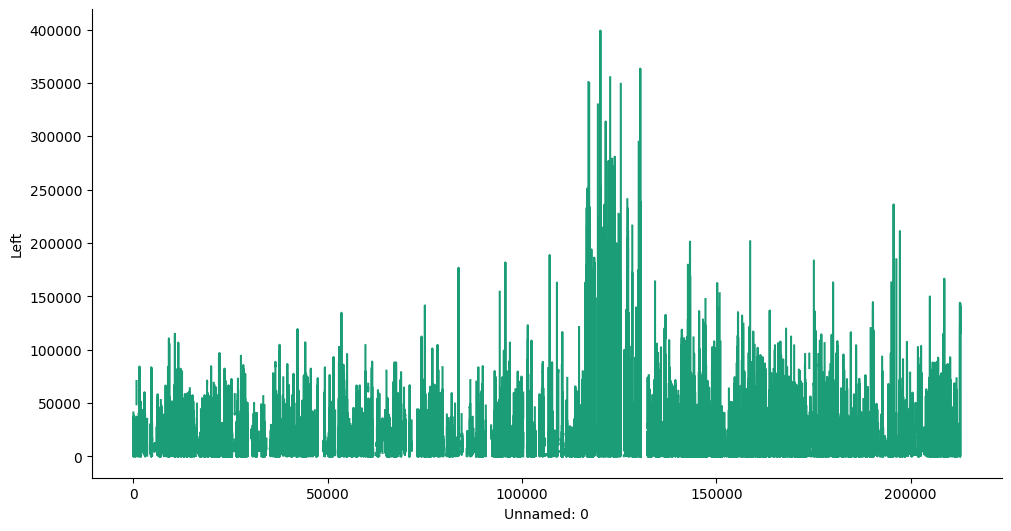

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Unnamed: 0']
  ys = series['Left']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = cleaned_df.sort_values('Unnamed: 0', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unnamed: 0')
_ = plt.ylabel('Left')

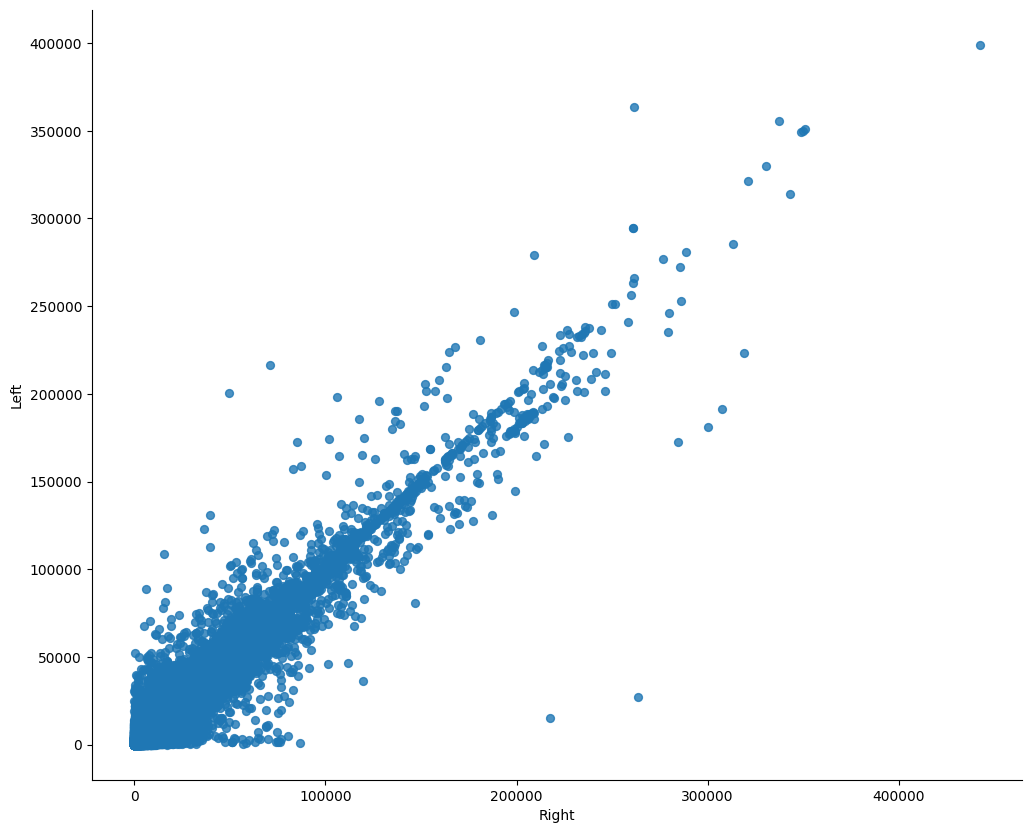

In [ ]:
from matplotlib import pyplot as plt
cleaned_df.plot(kind='scatter', x='Right', y='Left', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

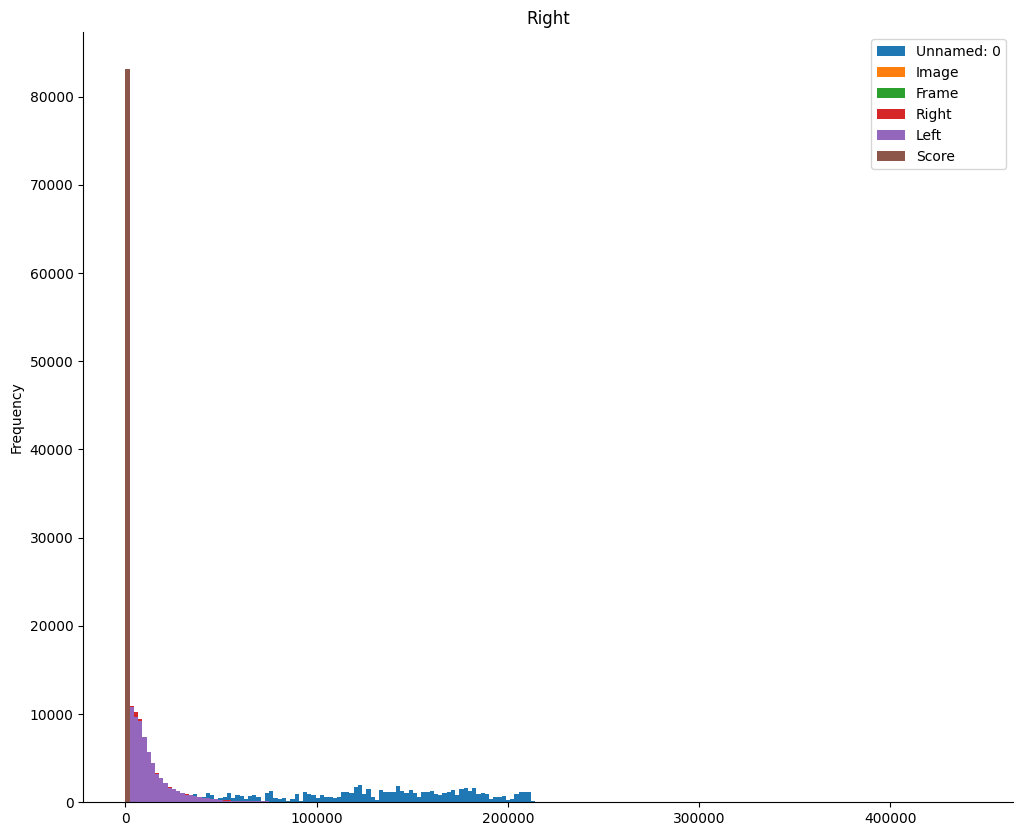

In [ ]:
from matplotlib import pyplot as plt
(cleaned_df[np.isfinite(cleaned_df['Right'])]).plot(kind='hist', bins=200, title='Right')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
ninf_df = cleaned_df[::]

In [ ]:

ninf_df.dtypes

Unnamed: 0      int64
Image         float64
Frame         float64
Right         float64
Left          float64
Score           int64
dtype: object

In [ ]:
ninf_df['Right'] = cleaned_df['Right'].replace([np.inf], 250000)
ninf_df['Left'] = cleaned_df['Left'].replace([np.inf], 250000)

In [ ]:
ninf_df.dtypes
ninf_df['Right'] = pd.to_numeric( ninf_df['Right'], errors='coerce')
ninf_df['Left'] = pd.to_numeric(ninf_df['Left'], errors='coerce')

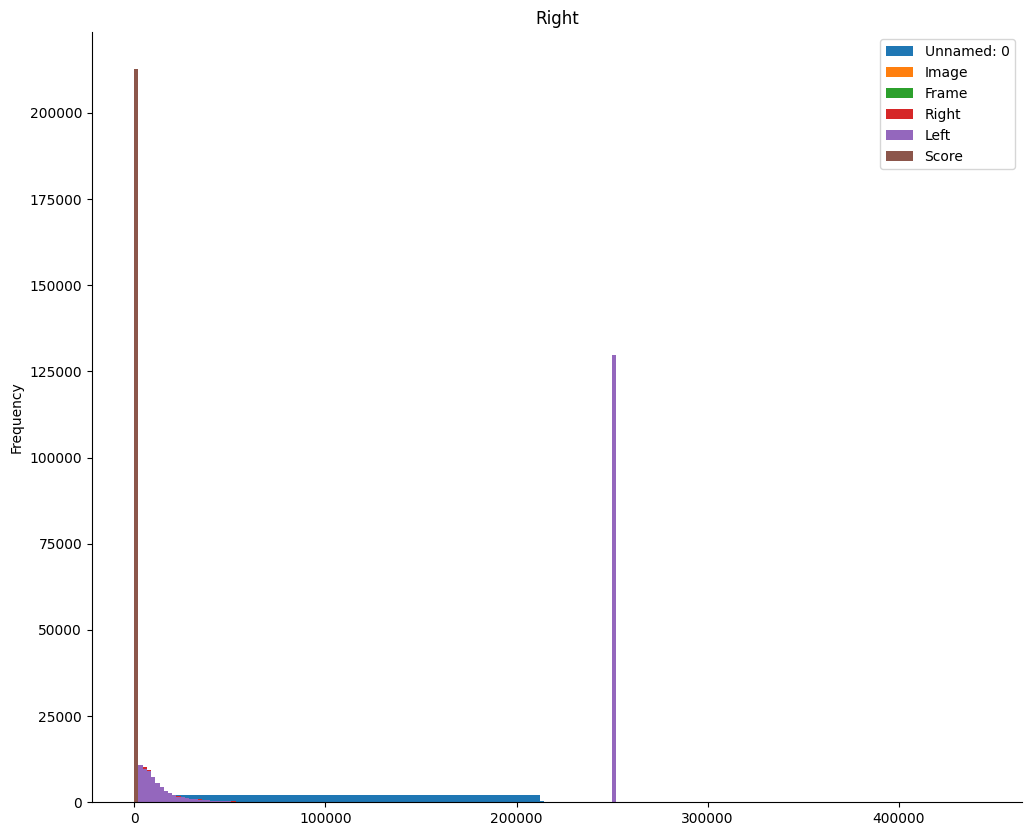

In [ ]:
from matplotlib import pyplot as plt
ninf_df.plot(kind='hist', bins=200, title='Right')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
ninf_df

,Unnamed: 0,Image,Frame,Right,Left,Score
0,2,1.0,1.0,12221.906250,17012.765625,0
1,3,1.0,2.0,647.080078,1127.886719,0
2,4,1.0,3.0,211.013672,291.878906,0
3,5,1.0,4.0,13664.328125,15937.546875,0
4,6,1.0,5.0,572.914062,810.605469,0
...,...,...,...,...,...,...
212751,212753,1058.0,198.0,1379.507812,1601.562500,0
212752,212754,1058.0,199.0,70134.531250,71327.546875,0
212753,212755,1058.0,200.0,112258.367188,114830.375000,0
212754,212756,1058.0,201.0,3447.617188,11639.828125,0


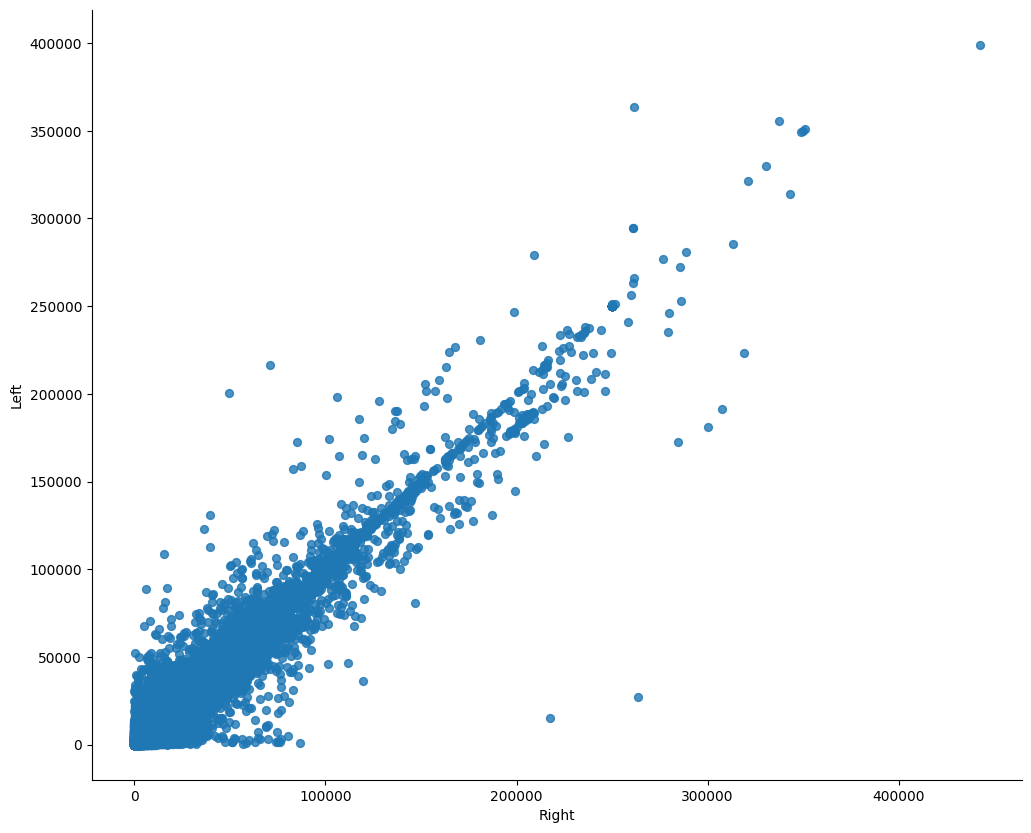

In [ ]:
from matplotlib import pyplot as plt
ninf_df.plot(kind='scatter', x='Right', y='Left', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:

df = cleaned_df.iloc[:,1:6]

In [ ]:

df = ninf_df.iloc[:,1:6]

We check whether the distribution of the classes in the three sets is about the same or not.

In [ ]:

df.iloc[41409:41600]


,Image,Frame,Right,Left,Score
41409,206.0,202.0,250000.0,250000.0,0
41410,207.0,1.0,250000.0,250000.0,1
41411,207.0,2.0,250000.0,250000.0,1
41412,207.0,3.0,250000.0,250000.0,1
41413,207.0,4.0,250000.0,250000.0,1
...,...,...,...,...,...
41595,207.0,186.0,250000.0,250000.0,1
41596,207.0,187.0,250000.0,250000.0,1
41597,207.0,188.0,250000.0,250000.0,1
41598,207.0,189.0,250000.0,250000.0,1


In [ ]:
df2.iloc[123839:124040]

NameError: ignored

In [ ]:
((df2.index[df2['Frame'] == 200.0])).to_list()


NameError: ignored

In [ ]:
df2 = df[::]

In [ ]:
df2.loc[123840.1] = 616.0,202.0,500000.0,500000.0,0
df2 = df2.sort_index().reset_index(drop=True)

<ipython-input-47-6af9f7a62356>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[123840.1] = 616.0,202.0,500000.0,500000.0,0


In [ ]:

df2.loc[192902.11] = 959.0,180.0,500000.0,500000.0,0

df2.loc[192902.12] = 959.0,181.0,500000.0,500000.0,0
df2.loc[192902.13] = 959.0,182.0,500000.0,500000.0,0
df2.loc[192902.14] = 959.0,183.0,500000.0,500000.0,0
df2.loc[192902.15] = 959.0,184.0,500000.0,500000.0,0
df2.loc[192902.16] = 959.0,185.0,500000.0,500000.0,0
df2.loc[192902.17] = 959.0,186.0,500000.0,500000.0,0
df2.loc[192902.18] = 959.0,187.0,500000.0,500000.0,0
df2.loc[192902.19] = 959.0,188.0,500000.0,500000.0,0
df2.loc[192902.20] = 959.0,189.0,500000.0,500000.0,0
df2.loc[192902.21] = 959.0,190.0,500000.0,500000.0,0

df2.loc[192902.22] = 959.0,191.0,500000.0,500000.0,0
df2.loc[192902.23] = 959.0,192.0,500000.0,500000.0,0
df2.loc[192902.24] = 959.0,193.0,500000.0,500000.0,0
df2.loc[192902.25] = 959.0,194.0,500000.0,500000.0,0
df2.loc[192902.26] = 959.0,195.0,500000.0,500000.0,0
df2.loc[192902.27] = 959.0,196.0,500000.0,500000.0,0
df2.loc[192902.28] = 959.0,197.0,500000.0,500000.0,0
df2.loc[192902.29] = 959.0,198.0,500000.0,500000.0,0
df2.loc[192902.30] = 959.0,199.0,500000.0,500000.0,0
df2.loc[192902.31] = 959.0,200.0,500000.0,500000.0,0
df2.loc[192902.32] = 959.0,201.0,500000.0,500000.0,0
df2.loc[192902.33] = 959.0,202.0,500000.0,500000.0,0


df2 = df2.sort_index().reset_index(drop=True)
#262 260 959

In [ ]:
df2.loc[118588.5] = 590.0,202.0,500000.0,500000.0,0


In [ ]:
df2.loc[51883] = 259.0,172.0,500000.0,500000.0,0

In [ ]:

df2 = df2.sort_index().reset_index(drop=True)


In [ ]:

df2.loc [119196: 119396]

,Image,Frame,Right,Left,Score
119196,594.0,144.0,250000.0,250000.0,0.0
119197,594.0,145.0,250000.0,250000.0,0.0
119198,594.0,146.0,250000.0,250000.0,0.0
119199,594.0,147.0,250000.0,250000.0,0.0
119200,594.0,148.0,250000.0,250000.0,0.0
...,...,...,...,...,...
119392,595.0,138.0,250000.0,250000.0,0.0
119393,595.0,139.0,250000.0,250000.0,0.0
119394,595.0,140.0,250000.0,250000.0,0.0
119395,595.0,141.0,250000.0,250000.0,0.0


In [ ]:
df2 = df2.drop([119196])

In [ ]:

df2 = df2.drop([52334,52335,52336,52337,52338,52339,52340,52341,52342,52343, 52344, 52345, 52346, 52347, 52348, 52349, 52350,52351])

In [ ]:

print((df2['Frame'] == 202.0).sum())

1048


In [ ]:
midx = pd.MultiIndex.from_frame(df2)
print(midx)

MultiIndex([(   1.0,   1.0,     12221.90625,    17012.765625, 0.0),
            (   1.0,   2.0,   647.080078125,   1127.88671875, 0.0),
            (   1.0,   3.0,   211.013671875,    291.87890625, 0.0),
            (   1.0,   4.0,    13664.328125,    15937.546875, 0.0),
            (   1.0,   5.0,     572.9140625,    810.60546875, 0.0),
            (   1.0,   6.0,  1249.416015625,   1724.66796875, 0.0),
            (   1.0,   7.0,    9410.1015625,  15003.77734375, 0.0),
            (   1.0,   8.0, 19286.318359375, 32184.849609375, 0.0),
            (   1.0,   9.0, 17339.736328125, 27947.654296875, 0.0),
            (   1.0,  10.0,  1718.275390625,   9811.94921875, 0.0),
            ...
            (1058.0, 193.0,   73978.1171875,   82542.5234375, 0.0),
            (1058.0, 194.0,     109748.9375,  114240.4140625, 0.0),
            (1058.0, 195.0,     142470.1875,   139859.484375, 0.0),
            (1058.0, 196.0,    830.41015625,   1831.30078125, 0.0),
            (1058.0, 197.0,   76

In [ ]:
df3 = df2.set_index(['Image','Frame'])



In [ ]:

df3

Right           Left  Score
Image  Frame                                     
1.0    1.0     12221.906250   17012.765625    0.0
       2.0       647.080078    1127.886719    0.0
       3.0       211.013672     291.878906    0.0
       4.0     13664.328125   15937.546875    0.0
       5.0       572.914062     810.605469    0.0
...                     ...            ...    ...
1058.0 198.0    1379.507812    1601.562500    0.0
       199.0   70134.531250   71327.546875    0.0
       200.0  112258.367188  114830.375000    0.0
       201.0    3447.617188   11639.828125    0.0
       202.0  113335.218750  115596.968750    0.0

[212757 rows x 3 columns]

In [ ]:
df3['Right'] = pd.Series.diff(df3['Right'])

In [ ]:
df3['Left'] = pd.Series.diff(df3['Left'])

In [ ]:
df3.describe()

,Right,Left,Score
count,212752.000000,212752.000000,212756.000000
mean,157518.277441,157546.732226,0.075946
std,116112.519767,116065.623490,0.264913
min,0.000000,0.000000,0.000000
25%,11373.168457,11559.118652,0.000000
50%,250000.000000,250000.000000,0.000000
75%,250000.000000,250000.000000,0.000000
max,442269.062500,399068.062500,1.000000


In [ ]:
df3.to_csv('ears_df3.csv', index=True)

In [ ]:
df3

Right           Left  Score
Image  Frame                                     
1.0    1.0     12221.906250   17012.765625    0.0
       2.0       647.080078    1127.886719    0.0
       3.0       211.013672     291.878906    0.0
       4.0     13664.328125   15937.546875    0.0
       5.0       572.914062     810.605469    0.0
...                     ...            ...    ...
1058.0 198.0    1379.507812    1601.562500    0.0
       199.0   70134.531250   71327.546875    0.0
       200.0  112258.367188  114830.375000    0.0
       201.0    3447.617188   11639.828125    0.0
       202.0  113335.218750  115596.968750    0.0

[212757 rows x 3 columns]

In [ ]:
df3.iloc[4000]

Right    250000.0
Left     250000.0
Score         0.0
Name: (20.0, 163.0), dtype: float64

In [ ]:
passing_list = ['0027','0053','0075','0083','0099','0117','0123','0125','0163','0169','0185','0207','0239','0263','0301','0345','0397','0421','0485','0579','0585','0589','0597','0601','0605','0611','0615','0619','0623','0627','0631','0635','0639','0643','0647','0651','0697','0725','0795','0827','0897','1005','1009','1029']


In [ ]:
df3.loc[df3['Right'] > 7500, 'Score'] = 0


In [ ]:
df3.loc[df3['Right'] < -7500, 'Score'] = 0


In [ ]:

df = df3[::]

In [ ]:
df

Right           Left  Score
Image  Frame                                     
1.0    1.0     12221.906250   17012.765625    0.0
       2.0       647.080078    1127.886719    0.0
       3.0       211.013672     291.878906    0.0
       4.0     13664.328125   15937.546875    0.0
       5.0       572.914062     810.605469    0.0
...                     ...            ...    ...
1058.0 198.0    1379.507812    1601.562500    0.0
       199.0   70134.531250   71327.546875    0.0
       200.0  112258.367188  114830.375000    0.0
       201.0    3447.617188   11639.828125    0.0
       202.0  113335.218750  115596.968750    0.0

[212757 rows x 3 columns]

In [ ]:
df.iloc[0]

Right    12221.906250
Left     17012.765625
Score        0.000000
Name: (1.0, 1.0), dtype: float64

In [ ]:

nan_rows = df[df['Image'].isnull()]
print(nan_rows)

KeyError: ignored

In [ ]:
df = df.drop([67338,80065,153793,160662])


In [ ]:
df = df.dropna()

In [ ]:

nan_rows = df[df['Left'].isnull()]
print(nan_rows)

Empty DataFrame
Columns: [Right, Left, Score]
Index: []


In [ ]:


# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Score'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Score'))
test_labels = np.array(test_df.pop('Score'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0107
Average class probability in validation set: 0.0111
Average class probability in test set:       0.0116


In [ ]:
print(train_features)

[[ 66997.4375  66997.4375]
 [250000.     250000.    ]
 [250000.     250000.    ]
 ...
 [250000.     250000.    ]
 [250000.     250000.    ]
 [250000.     250000.    ]]


In [ ]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

#train_features= np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (170202,)
Validation labels shape: (42551,)
Test labels shape: (42551,)
Training features shape: (170202, 2)
Validation features shape: (42551, 2)
Test features shape: (42551, 2)


[ True  True  True ...  True  True  True]


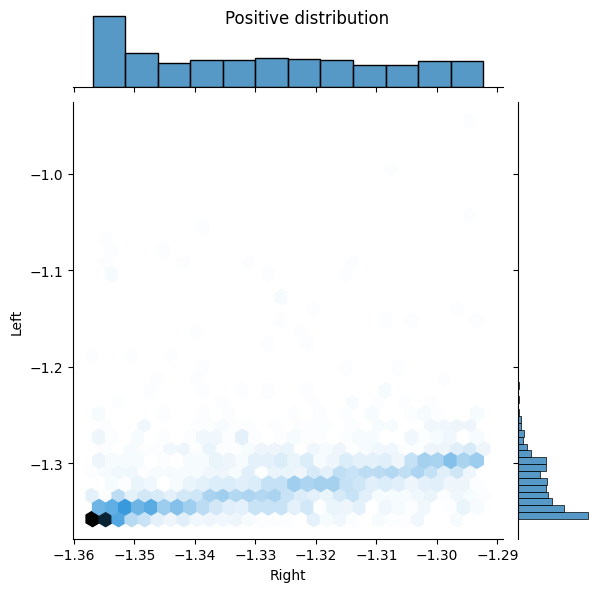

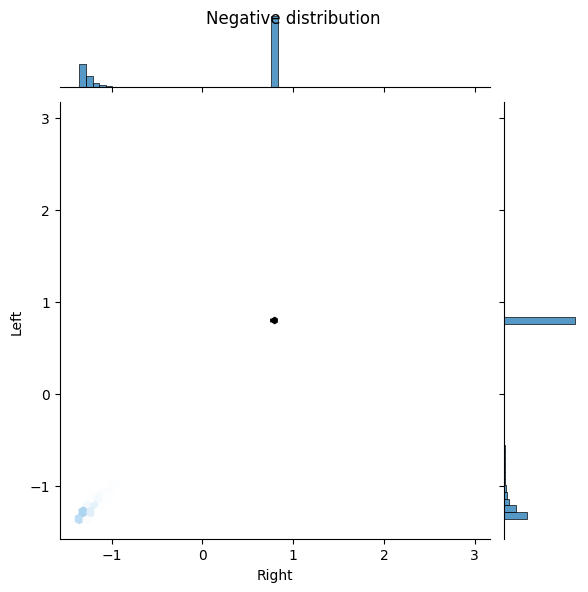

In [ ]:
print(~bool_train_labels)
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['Right'], y=pos_df['Left'],
              kind='hex')
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['Right'], y=neg_df['Left'],
              kind='hex')
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent:

In [ ]:
METRICS = [
      #keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'),
      #keras.metrics.BinaryAccuracy(name='accuracy'),
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Baseline model

In [1]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

NameError: ignored

In [ ]:
model = make_model()
model.summary()

In [ ]:
model.predict(train_features[:10])

In [ ]:
df.dtypes

In [ ]:
df

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=2)
print(results)
print("Loss: {:0.4f}".format(results[0]))

The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [ ]:
initial_bias = np.log([pos/neg])
initial_bias

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

In [ ]:
def plot_acc(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['accuracy'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_accuracy'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

In [ ]:
plot_acc(zero_bias_history, "Zero Bias", 0)
plot_acc(careful_bias_history, "Careful Bias", 1)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=500,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

In [ ]:
def plot_metrics(history):
  metrics = ['Brier score', 'auc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0,1])
    else:
      plt.ylim([0, plt.ylim()[1]])

    plt.legend()

In [ ]:
plot_metrics(baseline_history)

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [ ]:
plot_cm(test_labels, test_predictions_baseline, threshold=0.1)
plot_cm(test_labels, test_predictions_baseline, threshold=0.09)
plot_cm(test_labels, test_predictions_baseline, threshold=0.08)
plot_cm(test_labels, test_predictions_baseline, threshold=0.07)
plot_cm(test_labels, test_predictions_baseline, threshold=0.06)
plot_cm(test_labels, test_predictions_baseline, threshold=0.05)
plot_cm(test_labels, test_predictions_baseline, threshold=0.04)
plot_cm(test_labels, test_predictions_baseline, threshold=0.03)
plot_cm(test_labels, test_predictions_baseline, threshold=0.02)
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-0.5,20])
  #plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

## Class weights

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 6.58


In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
75/84 [=========================>....] - ETA: 0s - loss: 0.1965 - Brier score: 0.0178 - auc: 0.7527

84/84 [==============================] - 1s 7ms/step - loss: 0.1957 - Brier score: 0.0182 - auc: 0.7610 - val_loss: 0.1154 - val_Brier score: 0.0199 - val_auc: 0.9018
Epoch 2/100
83/84 [============================>.] - ETA: 0s - loss: 0.1727 - Brier score: 0.0267 - auc: 0.8219

84/84 [==============================] - 0s 5ms/step - loss: 0.1727 - Brier score: 0.0267 - auc: 0.8218 - val_loss: 0.1203 - val_Brier score: 0.0244 - val_auc: 0.9071
Epoch 3/100
73/84 [=========================>....] - ETA: 0s - loss: 0.1676 - Brier score: 0.0284 - auc: 0.8231

84/84 [==============================] - 0s 5ms/step - loss: 0.1677 - Brier score: 0.0285 - auc: 0.8224 - val_loss: 0.1158 - val_Brier score: 0.0246 - val_auc: 0.9055
Epoch 4/100
83/84 [============================>.] - ETA: 0s - loss: 0.1643 - Brier score: 0.0289 - auc: 0.8269

84/84 [==============================] - 0s 5ms/step - loss: 0.1642 - Brier score: 0.0289 - auc: 0.8270 - val_loss: 0.1142 - val_Brier score: 0.0249 - val_auc: 0.9081
Epoch 5/100
82/84 [============================>.] - ETA: 0s - loss: 0.1632 - Brier score: 0.0286 - auc: 0.8269

84/84 [==============================] - 1s 7ms/step - loss: 0.1634 - Brier score: 0.0286 - auc: 0.8273 - val_loss: 0.1151 - val_Brier score: 0.0257 - val_auc: 0.9082
Epoch 6/100
82/84 [============================>.] - ETA: 0s - loss: 0.1624 - Brier score: 0.0300 - auc: 0.8280

84/84 [==============================] - 1s 7ms/step - loss: 0.1626 - Brier score: 0.0300 - auc: 0.8276 - val_loss: 0.1090 - val_Brier score: 0.0239 - val_auc: 0.9064
Epoch 7/100
80/84 [===========================>..] - ETA: 0s - loss: 0.1626 - Brier score: 0.0278 - auc: 0.8232

84/84 [==============================] - 1s 8ms/step - loss: 0.1631 - Brier score: 0.0279 - auc: 0.8221 - val_loss: 0.1110 - val_Brier score: 0.0248 - val_auc: 0.9073
Epoch 8/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1622 - Brier score: 0.0278 - auc: 0.8246

84/84 [==============================] - 1s 8ms/step - loss: 0.1620 - Brier score: 0.0279 - auc: 0.8258 - val_loss: 0.1142 - val_Brier score: 0.0260 - val_auc: 0.9077
Epoch 9/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1602 - Brier score: 0.0289 - auc: 0.8293

84/84 [==============================] - 0s 5ms/step - loss: 0.1605 - Brier score: 0.0289 - auc: 0.8315 - val_loss: 0.1147 - val_Brier score: 0.0263 - val_auc: 0.9078
Epoch 10/100
81/84 [===========================>..] - ETA: 0s - loss: 0.1598 - Brier score: 0.0293 - auc: 0.8326

84/84 [==============================] - 0s 4ms/step - loss: 0.1601 - Brier score: 0.0293 - auc: 0.8328 - val_loss: 0.1143 - val_Brier score: 0.0262 - val_auc: 0.9081
Epoch 11/100
77/84 [==========================>...] - ETA: 0s - loss: 0.1591 - Brier score: 0.0295 - auc: 0.8332

84/84 [==============================] - 0s 4ms/step - loss: 0.1597 - Brier score: 0.0295 - auc: 0.8328 - val_loss: 0.1121 - val_Brier score: 0.0255 - val_auc: 0.9078
Epoch 12/100
71/84 [========================>.....] - ETA: 0s - loss: 0.1601 - Brier score: 0.0289 - auc: 0.8280

84/84 [==============================] - 0s 4ms/step - loss: 0.1598 - Brier score: 0.0289 - auc: 0.8297 - val_loss: 0.1130 - val_Brier score: 0.0258 - val_auc: 0.9094
Epoch 13/100
73/84 [=========================>....] - ETA: 0s - loss: 0.1599 - Brier score: 0.0293 - auc: 0.8288

84/84 [==============================] - 0s 5ms/step - loss: 0.1600 - Brier score: 0.0292 - auc: 0.8295 - val_loss: 0.1115 - val_Brier score: 0.0253 - val_auc: 0.9067
Epoch 14/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1586 - Brier score: 0.0289 - auc: 0.8354

84/84 [==============================] - 0s 5ms/step - loss: 0.1585 - Brier score: 0.0289 - auc: 0.8347 - val_loss: 0.1134 - val_Brier score: 0.0260 - val_auc: 0.9083
Epoch 15/100
75/84 [=========================>....] - ETA: 0s - loss: 0.1585 - Brier score: 0.0290 - auc: 0.8330

84/84 [==============================] - 0s 5ms/step - loss: 0.1587 - Brier score: 0.0290 - auc: 0.8340 - val_loss: 0.1141 - val_Brier score: 0.0263 - val_auc: 0.9088
Epoch 16/100
75/84 [=========================>....] - ETA: 0s - loss: 0.1598 - Brier score: 0.0292 - auc: 0.8322

84/84 [==============================] - 0s 5ms/step - loss: 0.1589 - Brier score: 0.0293 - auc: 0.8324 - val_loss: 0.1150 - val_Brier score: 0.0266 - val_auc: 0.9084
Epoch 17/100
84/84 [==============================] - ETA: 0s - loss: 0.1586 - Brier score: 0.0287 - auc: 0.8322

84/84 [==============================] - 0s 5ms/step - loss: 0.1586 - Brier score: 0.0287 - auc: 0.8322 - val_loss: 0.1140 - val_Brier score: 0.0263 - val_auc: 0.9078
Epoch 18/100
73/84 [=========================>....] - ETA: 0s - loss: 0.1577 - Brier score: 0.0287 - auc: 0.8329

84/84 [==============================] - 0s 5ms/step - loss: 0.1589 - Brier score: 0.0288 - auc: 0.8299 - val_loss: 0.1152 - val_Brier score: 0.0267 - val_auc: 0.9086
Epoch 19/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1584 - Brier score: 0.0287 - auc: 0.8315

84/84 [==============================] - 0s 4ms/step - loss: 0.1585 - Brier score: 0.0288 - auc: 0.8322 - val_loss: 0.1142 - val_Brier score: 0.0264 - val_auc: 0.9080
Epoch 20/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1578 - Brier score: 0.0296 - auc: 0.8354

84/84 [==============================] - 0s 4ms/step - loss: 0.1576 - Brier score: 0.0296 - auc: 0.8359 - val_loss: 0.1138 - val_Brier score: 0.0262 - val_auc: 0.9087
Epoch 21/100
81/84 [===========================>..] - ETA: 0s - loss: 0.1578 - Brier score: 0.0292 - auc: 0.8354

84/84 [==============================] - 0s 4ms/step - loss: 0.1573 - Brier score: 0.0292 - auc: 0.8361 - val_loss: 0.1117 - val_Brier score: 0.0255 - val_auc: 0.9089
Epoch 22/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1586 - Brier score: 0.0292 - auc: 0.8362

84/84 [==============================] - 0s 5ms/step - loss: 0.1575 - Brier score: 0.0291 - auc: 0.8357 - val_loss: 0.1139 - val_Brier score: 0.0263 - val_auc: 0.9075
Epoch 23/100
72/84 [========================>.....] - ETA: 0s - loss: 0.1555 - Brier score: 0.0278 - auc: 0.8332

84/84 [==============================] - 0s 4ms/step - loss: 0.1577 - Brier score: 0.0281 - auc: 0.8327 - val_loss: 0.1178 - val_Brier score: 0.0277 - val_auc: 0.9079
Epoch 24/100
77/84 [==========================>...] - ETA: 0s - loss: 0.1585 - Brier score: 0.0300 - auc: 0.8318

84/84 [==============================] - 0s 4ms/step - loss: 0.1579 - Brier score: 0.0298 - auc: 0.8318 - val_loss: 0.1143 - val_Brier score: 0.0264 - val_auc: 0.9104
Epoch 25/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1561 - Brier score: 0.0284 - auc: 0.8396

84/84 [==============================] - 0s 4ms/step - loss: 0.1566 - Brier score: 0.0286 - auc: 0.8375 - val_loss: 0.1182 - val_Brier score: 0.0278 - val_auc: 0.9092
Epoch 26/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1561 - Brier score: 0.0284 - auc: 0.8343

84/84 [==============================] - 0s 4ms/step - loss: 0.1567 - Brier score: 0.0287 - auc: 0.8358 - val_loss: 0.1200 - val_Brier score: 0.0285 - val_auc: 0.9090
Epoch 27/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1565 - Brier score: 0.0288 - auc: 0.8337

84/84 [==============================] - 0s 4ms/step - loss: 0.1565 - Brier score: 0.0287 - auc: 0.8345 - val_loss: 0.1140 - val_Brier score: 0.0265 - val_auc: 0.9081
Epoch 28/100
73/84 [=========================>....] - ETA: 0s - loss: 0.1534 - Brier score: 0.0288 - auc: 0.8488

84/84 [==============================] - 0s 4ms/step - loss: 0.1537 - Brier score: 0.0288 - auc: 0.8495 - val_loss: 0.1132 - val_Brier score: 0.0263 - val_auc: 0.9066
Epoch 29/100
75/84 [=========================>....] - ETA: 0s - loss: 0.1534 - Brier score: 0.0288 - auc: 0.8514

84/84 [==============================] - 0s 5ms/step - loss: 0.1529 - Brier score: 0.0288 - auc: 0.8522 - val_loss: 0.1122 - val_Brier score: 0.0260 - val_auc: 0.9061
Epoch 30/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1532 - Brier score: 0.0275 - auc: 0.8454

84/84 [==============================] - 0s 5ms/step - loss: 0.1537 - Brier score: 0.0276 - auc: 0.8472 - val_loss: 0.1150 - val_Brier score: 0.0270 - val_auc: 0.9060
Epoch 31/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1517 - Brier score: 0.0293 - auc: 0.8547

84/84 [==============================] - 0s 4ms/step - loss: 0.1520 - Brier score: 0.0293 - auc: 0.8553 - val_loss: 0.1150 - val_Brier score: 0.0271 - val_auc: 0.9051
Epoch 32/100
78/84 [==========================>...] - ETA: 0s - loss: 0.1522 - Brier score: 0.0287 - auc: 0.8538

84/84 [==============================] - 0s 4ms/step - loss: 0.1522 - Brier score: 0.0287 - auc: 0.8540 - val_loss: 0.1141 - val_Brier score: 0.0268 - val_auc: 0.9060
Epoch 33/100
73/84 [=========================>....] - ETA: 0s - loss: 0.1511 - Brier score: 0.0283 - auc: 0.8561

84/84 [==============================] - 0s 5ms/step - loss: 0.1513 - Brier score: 0.0282 - auc: 0.8575 - val_loss: 0.1124 - val_Brier score: 0.0265 - val_auc: 0.9012
Epoch 34/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1502 - Brier score: 0.0291 - auc: 0.8615

84/84 [==============================] - 1s 6ms/step - loss: 0.1502 - Brier score: 0.0291 - auc: 0.8616 - val_loss: 0.1102 - val_Brier score: 0.0258 - val_auc: 0.9024
Epoch 35/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1498 - Brier score: 0.0288 - auc: 0.8626

84/84 [==============================] - 1s 8ms/step - loss: 0.1497 - Brier score: 0.0287 - auc: 0.8630 - val_loss: 0.1096 - val_Brier score: 0.0256 - val_auc: 0.9024
Epoch 36/100
80/84 [===========================>..] - ETA: 0s - loss: 0.1485 - Brier score: 0.0288 - auc: 0.8651

84/84 [==============================] - 1s 7ms/step - loss: 0.1493 - Brier score: 0.0287 - auc: 0.8649 - val_loss: 0.1091 - val_Brier score: 0.0255 - val_auc: 0.9025
Epoch 37/100
80/84 [===========================>..] - ETA: 0s - loss: 0.1484 - Brier score: 0.0289 - auc: 0.8671

84/84 [==============================] - 1s 7ms/step - loss: 0.1486 - Brier score: 0.0289 - auc: 0.8667 - val_loss: 0.1109 - val_Brier score: 0.0262 - val_auc: 0.9023
Epoch 38/100
78/84 [==========================>...] - ETA: 0s - loss: 0.1483 - Brier score: 0.0282 - auc: 0.8668

84/84 [==============================] - 1s 6ms/step - loss: 0.1487 - Brier score: 0.0284 - auc: 0.8662 - val_loss: 0.1145 - val_Brier score: 0.0276 - val_auc: 0.9017
Epoch 39/100
82/84 [============================>.] - ETA: 0s - loss: 0.1483 - Brier score: 0.0291 - auc: 0.8688

84/84 [==============================] - 0s 5ms/step - loss: 0.1481 - Brier score: 0.0291 - auc: 0.8686 - val_loss: 0.1130 - val_Brier score: 0.0271 - val_auc: 0.9018
Epoch 40/100
75/84 [=========================>....] - ETA: 0s - loss: 0.1471 - Brier score: 0.0293 - auc: 0.8719

84/84 [==============================] - 0s 5ms/step - loss: 0.1473 - Brier score: 0.0293 - auc: 0.8722 - val_loss: 0.1144 - val_Brier score: 0.0276 - val_auc: 0.9021
Epoch 41/100
72/84 [========================>.....] - ETA: 0s - loss: 0.1466 - Brier score: 0.0295 - auc: 0.8736

84/84 [==============================] - 0s 4ms/step - loss: 0.1467 - Brier score: 0.0293 - auc: 0.8746 - val_loss: 0.1115 - val_Brier score: 0.0266 - val_auc: 0.9025
Epoch 42/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1464 - Brier score: 0.0287 - auc: 0.8698

84/84 [==============================] - 0s 4ms/step - loss: 0.1475 - Brier score: 0.0288 - auc: 0.8696 - val_loss: 0.1146 - val_Brier score: 0.0278 - val_auc: 0.9025
Epoch 43/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1461 - Brier score: 0.0289 - auc: 0.8740

84/84 [==============================] - 0s 4ms/step - loss: 0.1465 - Brier score: 0.0289 - auc: 0.8742 - val_loss: 0.1149 - val_Brier score: 0.0280 - val_auc: 0.9028
Epoch 44/100
71/84 [========================>.....] - ETA: 0s - loss: 0.1457 - Brier score: 0.0284 - auc: 0.8777

84/84 [==============================] - 0s 4ms/step - loss: 0.1458 - Brier score: 0.0287 - auc: 0.8772 - val_loss: 0.1104 - val_Brier score: 0.0267 - val_auc: 0.9021
Epoch 45/100
75/84 [=========================>....] - ETA: 0s - loss: 0.1464 - Brier score: 0.0289 - auc: 0.8798

84/84 [==============================] - 0s 4ms/step - loss: 0.1446 - Brier score: 0.0290 - auc: 0.8793 - val_loss: 0.1084 - val_Brier score: 0.0262 - val_auc: 0.9019
Epoch 46/100
78/84 [==========================>...] - ETA: 0s - loss: 0.1446 - Brier score: 0.0282 - auc: 0.8808

84/84 [==============================] - 0s 4ms/step - loss: 0.1445 - Brier score: 0.0282 - auc: 0.8806 - val_loss: 0.1092 - val_Brier score: 0.0265 - val_auc: 0.9021
Epoch 47/100
83/84 [============================>.] - ETA: 0s - loss: 0.1443 - Brier score: 0.0289 - auc: 0.8801

84/84 [==============================] - 0s 5ms/step - loss: 0.1444 - Brier score: 0.0289 - auc: 0.8801 - val_loss: 0.1066 - val_Brier score: 0.0257 - val_auc: 0.9022
Epoch 48/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1443 - Brier score: 0.0298 - auc: 0.8826

84/84 [==============================] - 0s 5ms/step - loss: 0.1435 - Brier score: 0.0297 - auc: 0.8827 - val_loss: 0.1045 - val_Brier score: 0.0250 - val_auc: 0.9019
Epoch 49/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1439 - Brier score: 0.0285 - auc: 0.8839

84/84 [==============================] - 0s 5ms/step - loss: 0.1434 - Brier score: 0.0285 - auc: 0.8834 - val_loss: 0.1099 - val_Brier score: 0.0269 - val_auc: 0.9024
Epoch 50/100
77/84 [==========================>...] - ETA: 0s - loss: 0.1431 - Brier score: 0.0281 - auc: 0.8844

84/84 [==============================] - 0s 4ms/step - loss: 0.1432 - Brier score: 0.0282 - auc: 0.8833 - val_loss: 0.1109 - val_Brier score: 0.0274 - val_auc: 0.9018
Epoch 51/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1432 - Brier score: 0.0300 - auc: 0.8839

84/84 [==============================] - 0s 4ms/step - loss: 0.1429 - Brier score: 0.0298 - auc: 0.8839 - val_loss: 0.1047 - val_Brier score: 0.0252 - val_auc: 0.9030
Epoch 52/100
80/84 [===========================>..] - ETA: 0s - loss: 0.1420 - Brier score: 0.0285 - auc: 0.8863

84/84 [==============================] - 0s 5ms/step - loss: 0.1425 - Brier score: 0.0285 - auc: 0.8861 - val_loss: 0.1091 - val_Brier score: 0.0269 - val_auc: 0.9023
Epoch 53/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1414 - Brier score: 0.0288 - auc: 0.8889

84/84 [==============================] - 0s 4ms/step - loss: 0.1417 - Brier score: 0.0291 - auc: 0.8887 - val_loss: 0.1184 - val_Brier score: 0.0304 - val_auc: 0.9032
Epoch 54/100
75/84 [=========================>....] - ETA: 0s - loss: 0.1428 - Brier score: 0.0301 - auc: 0.8850

84/84 [==============================] - 0s 5ms/step - loss: 0.1422 - Brier score: 0.0301 - auc: 0.8855 - val_loss: 0.1073 - val_Brier score: 0.0264 - val_auc: 0.9026
Epoch 55/100
70/84 [========================>.....] - ETA: 0s - loss: 0.1417 - Brier score: 0.0289 - auc: 0.8870

84/84 [==============================] - 0s 5ms/step - loss: 0.1416 - Brier score: 0.0291 - auc: 0.8877 - val_loss: 0.1102 - val_Brier score: 0.0274 - val_auc: 0.9023
Epoch 56/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1425 - Brier score: 0.0296 - auc: 0.8889

84/84 [==============================] - 0s 5ms/step - loss: 0.1416 - Brier score: 0.0295 - auc: 0.8883 - val_loss: 0.1060 - val_Brier score: 0.0260 - val_auc: 0.9023
Epoch 57/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1407 - Brier score: 0.0289 - auc: 0.8902

84/84 [==============================] - 0s 5ms/step - loss: 0.1411 - Brier score: 0.0290 - auc: 0.8899 - val_loss: 0.1120 - val_Brier score: 0.0282 - val_auc: 0.9026
Epoch 58/100
75/84 [=========================>....] - ETA: 0s - loss: 0.1407 - Brier score: 0.0295 - auc: 0.8900

84/84 [==============================] - 0s 4ms/step - loss: 0.1409 - Brier score: 0.0296 - auc: 0.8890 - val_loss: 0.1100 - val_Brier score: 0.0276 - val_auc: 0.9031
Epoch 59/100
82/84 [============================>.] - ETA: 0s - loss: 0.1411 - Brier score: 0.0292 - auc: 0.8889

84/84 [==============================] - 0s 5ms/step - loss: 0.1411 - Brier score: 0.0293 - auc: 0.8890 - val_loss: 0.1149 - val_Brier score: 0.0294 - val_auc: 0.9034
Epoch 60/100
84/84 [==============================] - ETA: 0s - loss: 0.1398 - Brier score: 0.0300 - auc: 0.8932

84/84 [==============================] - 0s 5ms/step - loss: 0.1398 - Brier score: 0.0300 - auc: 0.8932 - val_loss: 0.1139 - val_Brier score: 0.0292 - val_auc: 0.9027
Epoch 61/100
72/84 [========================>.....] - ETA: 0s - loss: 0.1422 - Brier score: 0.0299 - auc: 0.8887

84/84 [==============================] - 0s 5ms/step - loss: 0.1411 - Brier score: 0.0298 - auc: 0.8884 - val_loss: 0.1077 - val_Brier score: 0.0268 - val_auc: 0.9025
Epoch 62/100
73/84 [=========================>....] - ETA: 0s - loss: 0.1403 - Brier score: 0.0290 - auc: 0.8904

84/84 [==============================] - 0s 4ms/step - loss: 0.1403 - Brier score: 0.0289 - auc: 0.8917 - val_loss: 0.1078 - val_Brier score: 0.0271 - val_auc: 0.9029
Epoch 63/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1399 - Brier score: 0.0302 - auc: 0.8920

84/84 [==============================] - 0s 4ms/step - loss: 0.1400 - Brier score: 0.0305 - auc: 0.8910 - val_loss: 0.1123 - val_Brier score: 0.0287 - val_auc: 0.9033
Epoch 64/100
81/84 [===========================>..] - ETA: 0s - loss: 0.1400 - Brier score: 0.0298 - auc: 0.8907

84/84 [==============================] - 1s 8ms/step - loss: 0.1402 - Brier score: 0.0298 - auc: 0.8906 - val_loss: 0.1054 - val_Brier score: 0.0261 - val_auc: 0.9037
Epoch 65/100
77/84 [==========================>...] - ETA: 0s - loss: 0.1404 - Brier score: 0.0292 - auc: 0.8904

84/84 [==============================] - 1s 7ms/step - loss: 0.1403 - Brier score: 0.0293 - auc: 0.8913 - val_loss: 0.1100 - val_Brier score: 0.0280 - val_auc: 0.9035
Epoch 66/100
80/84 [===========================>..] - ETA: 0s - loss: 0.1403 - Brier score: 0.0297 - auc: 0.8910

84/84 [==============================] - 1s 8ms/step - loss: 0.1395 - Brier score: 0.0297 - auc: 0.8914 - val_loss: 0.1019 - val_Brier score: 0.0254 - val_auc: 0.9040
Epoch 67/100
80/84 [===========================>..] - ETA: 0s - loss: 0.1390 - Brier score: 0.0298 - auc: 0.8938

84/84 [==============================] - 1s 7ms/step - loss: 0.1384 - Brier score: 0.0298 - auc: 0.8937 - val_loss: 0.1120 - val_Brier score: 0.0291 - val_auc: 0.9045
Epoch 68/100
80/84 [===========================>..] - ETA: 0s - loss: 0.1377 - Brier score: 0.0302 - auc: 0.8960

84/84 [==============================] - 0s 6ms/step - loss: 0.1377 - Brier score: 0.0302 - auc: 0.8957 - val_loss: 0.1087 - val_Brier score: 0.0280 - val_auc: 0.9044
Epoch 69/100
72/84 [========================>.....] - ETA: 0s - loss: 0.1363 - Brier score: 0.0294 - auc: 0.8976

84/84 [==============================] - 0s 5ms/step - loss: 0.1373 - Brier score: 0.0297 - auc: 0.8971 - val_loss: 0.1138 - val_Brier score: 0.0298 - val_auc: 0.9044
Epoch 70/100
70/84 [========================>.....] - ETA: 0s - loss: 0.1377 - Brier score: 0.0301 - auc: 0.8960

84/84 [==============================] - 0s 4ms/step - loss: 0.1378 - Brier score: 0.0299 - auc: 0.8960 - val_loss: 0.1095 - val_Brier score: 0.0284 - val_auc: 0.9048
Epoch 71/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1368 - Brier score: 0.0294 - auc: 0.8968

84/84 [==============================] - 0s 5ms/step - loss: 0.1374 - Brier score: 0.0295 - auc: 0.8969 - val_loss: 0.1167 - val_Brier score: 0.0312 - val_auc: 0.9051
Epoch 72/100
81/84 [===========================>..] - ETA: 0s - loss: 0.1366 - Brier score: 0.0310 - auc: 0.8970

84/84 [==============================] - 0s 5ms/step - loss: 0.1370 - Brier score: 0.0310 - auc: 0.8969 - val_loss: 0.1074 - val_Brier score: 0.0278 - val_auc: 0.9048
Epoch 73/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1356 - Brier score: 0.0301 - auc: 0.9012

84/84 [==============================] - 0s 5ms/step - loss: 0.1359 - Brier score: 0.0301 - auc: 0.9006 - val_loss: 0.1081 - val_Brier score: 0.0283 - val_auc: 0.9047
Epoch 74/100
72/84 [========================>.....] - ETA: 0s - loss: 0.1362 - Brier score: 0.0310 - auc: 0.8986

84/84 [==============================] - 0s 5ms/step - loss: 0.1361 - Brier score: 0.0310 - auc: 0.8978 - val_loss: 0.1094 - val_Brier score: 0.0286 - val_auc: 0.9039
Epoch 75/100
70/84 [========================>.....] - ETA: 0s - loss: 0.1364 - Brier score: 0.0300 - auc: 0.8984

84/84 [==============================] - 0s 5ms/step - loss: 0.1362 - Brier score: 0.0303 - auc: 0.8987 - val_loss: 0.1124 - val_Brier score: 0.0299 - val_auc: 0.9057
Epoch 76/100
73/84 [=========================>....] - ETA: 0s - loss: 0.1371 - Brier score: 0.0305 - auc: 0.8982

84/84 [==============================] - 0s 5ms/step - loss: 0.1365 - Brier score: 0.0304 - auc: 0.8976 - val_loss: 0.1066 - val_Brier score: 0.0278 - val_auc: 0.9055
Epoch 77/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1363 - Brier score: 0.0306 - auc: 0.8982

84/84 [==============================] - 0s 5ms/step - loss: 0.1361 - Brier score: 0.0306 - auc: 0.8977 - val_loss: 0.1066 - val_Brier score: 0.0278 - val_auc: 0.9054
Epoch 78/100
75/84 [=========================>....] - ETA: 0s - loss: 0.1369 - Brier score: 0.0300 - auc: 0.8973

84/84 [==============================] - 0s 4ms/step - loss: 0.1367 - Brier score: 0.0299 - auc: 0.8957 - val_loss: 0.1099 - val_Brier score: 0.0289 - val_auc: 0.9056
Epoch 79/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1363 - Brier score: 0.0309 - auc: 0.8980

84/84 [==============================] - 0s 5ms/step - loss: 0.1361 - Brier score: 0.0308 - auc: 0.8978 - val_loss: 0.1067 - val_Brier score: 0.0278 - val_auc: 0.9059
Epoch 80/100
84/84 [==============================] - ETA: 0s - loss: 0.1356 - Brier score: 0.0305 - auc: 0.9003

84/84 [==============================] - 0s 5ms/step - loss: 0.1356 - Brier score: 0.0305 - auc: 0.9003 - val_loss: 0.1051 - val_Brier score: 0.0276 - val_auc: 0.9047
Epoch 81/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1362 - Brier score: 0.0300 - auc: 0.8991

84/84 [==============================] - 0s 4ms/step - loss: 0.1354 - Brier score: 0.0302 - auc: 0.9002 - val_loss: 0.1094 - val_Brier score: 0.0291 - val_auc: 0.9059
Epoch 82/100
71/84 [========================>.....] - ETA: 0s - loss: 0.1356 - Brier score: 0.0307 - auc: 0.8989

84/84 [==============================] - 0s 5ms/step - loss: 0.1358 - Brier score: 0.0307 - auc: 0.8976 - val_loss: 0.1043 - val_Brier score: 0.0272 - val_auc: 0.9051
Epoch 83/100
82/84 [============================>.] - ETA: 0s - loss: 0.1359 - Brier score: 0.0302 - auc: 0.8993

84/84 [==============================] - 0s 5ms/step - loss: 0.1357 - Brier score: 0.0302 - auc: 0.8994 - val_loss: 0.1068 - val_Brier score: 0.0282 - val_auc: 0.9052
Epoch 84/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1348 - Brier score: 0.0301 - auc: 0.9002

84/84 [==============================] - 0s 5ms/step - loss: 0.1353 - Brier score: 0.0302 - auc: 0.9000 - val_loss: 0.1135 - val_Brier score: 0.0306 - val_auc: 0.9059
Epoch 85/100
83/84 [============================>.] - ETA: 0s - loss: 0.1351 - Brier score: 0.0312 - auc: 0.8995

84/84 [==============================] - 0s 5ms/step - loss: 0.1351 - Brier score: 0.0312 - auc: 0.8994 - val_loss: 0.1009 - val_Brier score: 0.0260 - val_auc: 0.9052
Epoch 86/100
70/84 [========================>.....] - ETA: 0s - loss: 0.1355 - Brier score: 0.0309 - auc: 0.9003

84/84 [==============================] - 0s 5ms/step - loss: 0.1349 - Brier score: 0.0305 - auc: 0.9004 - val_loss: 0.1018 - val_Brier score: 0.0264 - val_auc: 0.9054
Epoch 87/100
79/84 [===========================>..] - ETA: 0s - loss: 0.1353 - Brier score: 0.0309 - auc: 0.9006

84/84 [==============================] - 0s 5ms/step - loss: 0.1351 - Brier score: 0.0310 - auc: 0.9010 - val_loss: 0.1093 - val_Brier score: 0.0291 - val_auc: 0.9065
Epoch 88/100
76/84 [==========================>...] - ETA: 0s - loss: 0.1353 - Brier score: 0.0305 - auc: 0.8984

84/84 [==============================] - 0s 5ms/step - loss: 0.1353 - Brier score: 0.0307 - auc: 0.8986 - val_loss: 0.1118 - val_Brier score: 0.0301 - val_auc: 0.9074
Epoch 89/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1363 - Brier score: 0.0311 - auc: 0.8997

84/84 [==============================] - 0s 5ms/step - loss: 0.1352 - Brier score: 0.0312 - auc: 0.9002 - val_loss: 0.1060 - val_Brier score: 0.0280 - val_auc: 0.9064
Epoch 90/100
74/84 [=========================>....] - ETA: 0s - loss: 0.1359 - Brier score: 0.0305 - auc: 0.8991

84/84 [==============================] - 0s 4ms/step - loss: 0.1349 - Brier score: 0.0306 - auc: 0.8992 - val_loss: 0.1075 - val_Brier score: 0.0287 - val_auc: 0.9060
Epoch 91/100
77/84 [==========================>...] - ETA: 0s - loss: 0.1336 - Brier score: 0.0305 - auc: 0.9025

84/84 [==============================] - 0s 4ms/step - loss: 0.1343 - Brier score: 0.0306 - auc: 0.9017 - val_loss: 0.1086 - val_Brier score: 0.0292 - val_auc: 0.9067
Epoch 92/100
77/84 [==========================>...] - ETA: 0s - loss: 0.1339 - Brier score: 0.0311 - auc: 0.9013

84/84 [==============================] - 0s 5ms/step - loss: 0.1338 - Brier score: 0.0312 - auc: 0.9016 - val_loss: 0.1156 - val_Brier score: 0.0319 - val_auc: 0.9079
Epoch 93/100
82/84 [============================>.] - ETA: 0s - loss: 0.1342 - Brier score: 0.0312 - auc: 0.8995

84/84 [==============================] - 1s 8ms/step - loss: 0.1342 - Brier score: 0.0311 - auc: 0.8998 - val_loss: 0.1024 - val_Brier score: 0.0270 - val_auc: 0.9058
Epoch 94/100
82/84 [============================>.] - ETA: 0s - loss: 0.1343 - Brier score: 0.0313 - auc: 0.9007

84/84 [==============================] - 1s 7ms/step - loss: 0.1342 - Brier score: 0.0313 - auc: 0.9007 - val_loss: 0.1090 - val_Brier score: 0.0295 - val_auc: 0.9059
Epoch 95/100
78/84 [==========================>...] - ETA: 0s - loss: 0.1349 - Brier score: 0.0313 - auc: 0.9016

84/84 [==============================] - 1s 8ms/step - loss: 0.1338 - Brier score: 0.0313 - auc: 0.9020 - val_loss: 0.1101 - val_Brier score: 0.0299 - val_auc: 0.9073
Epoch 96/100
80/84 [===========================>..] - ETA: 0s - loss: 0.1345 - Brier score: 0.0313 - auc: 0.9011

84/84 [==============================] - 1s 8ms/step - loss: 0.1341 - Brier score: 0.0313 - auc: 0.9008 - val_loss: 0.1082 - val_Brier score: 0.0291 - val_auc: 0.9069
Epoch 97/100
82/84 [============================>.] - ETA: 0s - loss: 0.1336 - Brier score: 0.0304 - auc: 0.9019

84/84 [==============================] - 0s 5ms/step - loss: 0.1338 - Brier score: 0.0304 - auc: 0.9016 - val_loss: 0.1096 - val_Brier score: 0.0298 - val_auc: 0.9073
Epoch 98/100
84/84 [==============================] - ETA: 0s - loss: 0.1333 - Brier score: 0.0312 - auc: 0.9025

84/84 [==============================] - 0s 5ms/step - loss: 0.1333 - Brier score: 0.0312 - auc: 0.9025 - val_loss: 0.1098 - val_Brier score: 0.0303 - val_auc: 0.9067
Epoch 99/100
81/84 [===========================>..] - ETA: 0s - loss: 0.1327 - Brier score: 0.0318 - auc: 0.9028

84/84 [==============================] - 0s 5ms/step - loss: 0.1327 - Brier score: 0.0318 - auc: 0.9028 - val_loss: 0.1087 - val_Brier score: 0.0301 - val_auc: 0.9073
Epoch 100/100
83/84 [============================>.] - ETA: 0s - loss: 0.1325 - Brier score: 0.0314 - auc: 0.9029

84/84 [==============================] - 0s 5ms/step - loss: 0.1324 - Brier score: 0.0314 - auc: 0.9029 - val_loss: 0.1089 - val_Brier score: 0.0299 - val_auc: 0.9074


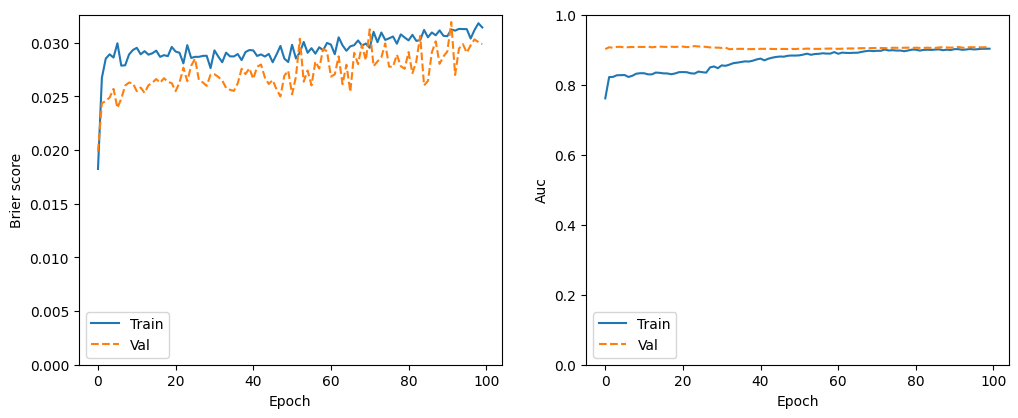

In [ ]:
plot_metrics(weighted_history)

### Evaluate metrics

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

### Plot the ROC

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the PRC

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

In [ ]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data.

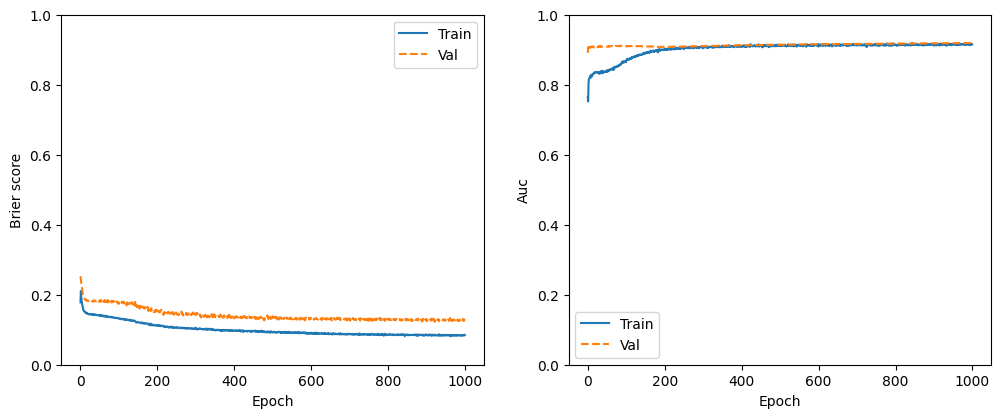

In [ ]:
plot_metrics(resampled_history)

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.3338557183742523
cross entropy :  0.3338557183742523
Brier score :  0.12584909796714783
tp :  492.0
fp :  7799.0
tn :  34260.0
fn :  0.0
accuracy :  0.8167140483856201
precision :  0.05934145301580429
recall :  1.0
auc :  0.9222425222396851
prc :  0.0855167955160141

Legitimate Transactions Detected (True Negatives):  34260
Legitimate Transactions Incorrectly Detected (False Positives):  7799
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  492
Total Fraudulent Transactions:  492


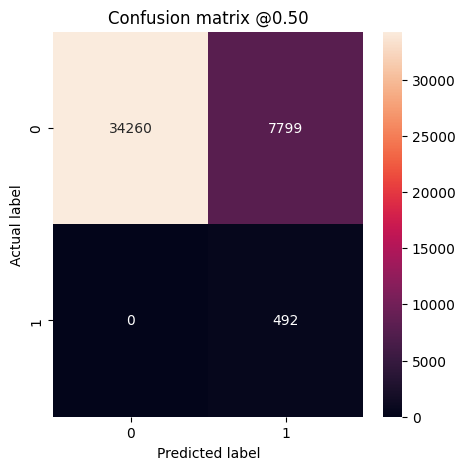

In [ ]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

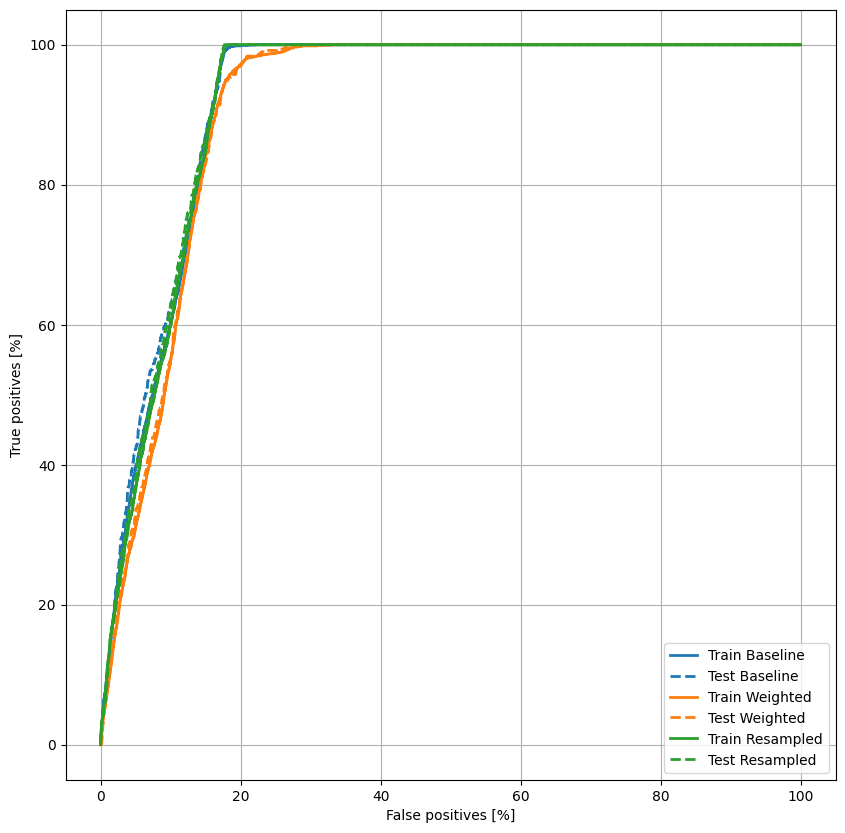

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


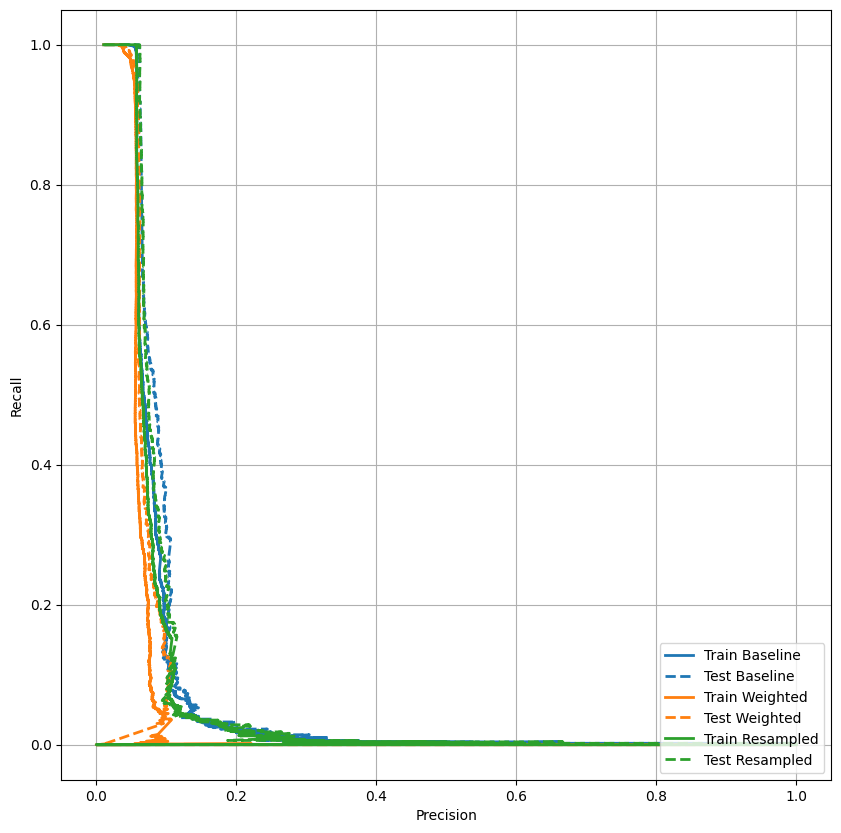

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');